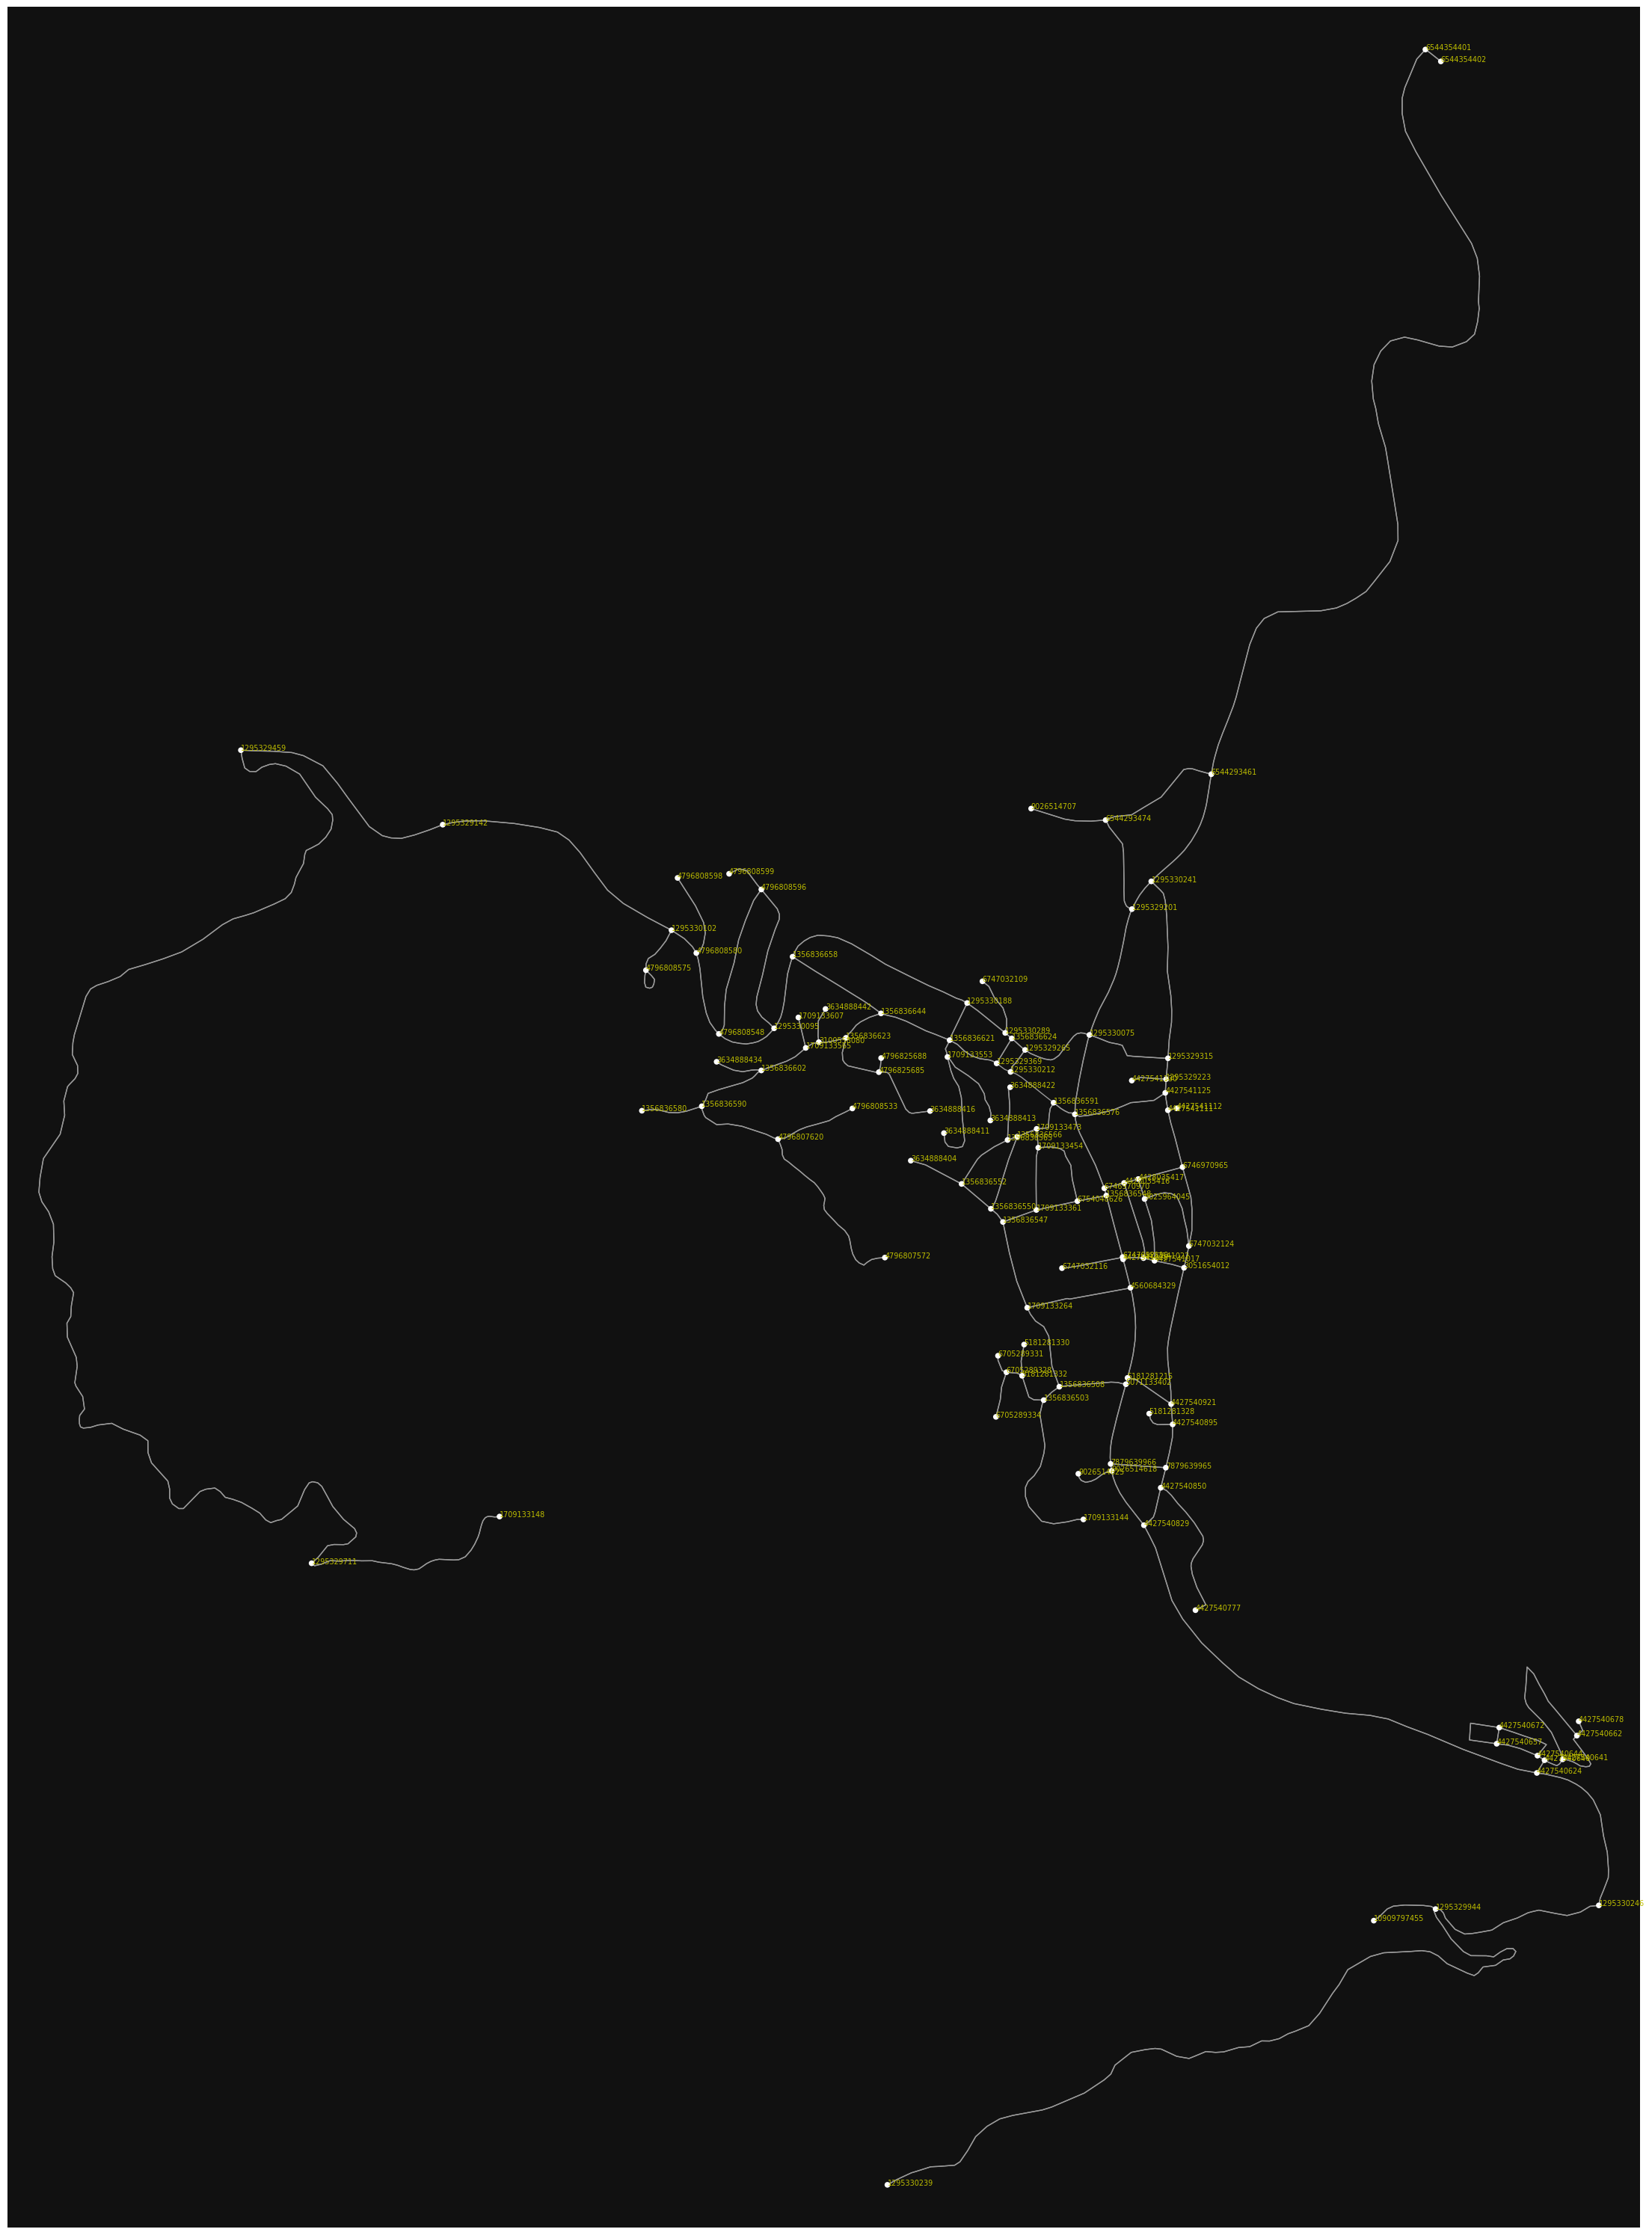

In [1]:
import networkx as nx
import osmnx as ox
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

G = ox.graph_from_place("Mežica, Slovenia", network_type="drive", simplify="False")
fig, ax = ox.plot_graph(G, figsize=(58.33, 38.57), dpi=100, node_size=30, show=False, close=False)

# seznam osmnid-jev vozlisc
nodes_list = list(G.nodes)
# seznam povezav in atributov lanes, name, maxspeed, length, noter bomo shranili le enosmerne ceste, po tem ko vse dvosmerne spremenimo v dve enosmerni
edges_list = []

# pretvorimo graf G v dva GeoDataFrame-a, enega za vozlisca in enega za povezave
nodes, edges = ox.graph_to_gdfs(G)

for i, row in nodes.iterrows():
    attr = row.to_dict()
    text = i
    c = attr['geometry']
    ax.annotate(text, (c.x, c.y), c='y', fontsize='x-small')
plt.show()
ox.plot_graph_folium(G)

In [2]:
# funckcija za računanje povprečne vrednosti v primeru seznama
def average(l):
    if isinstance(l, list):
        lst = []
        for i in l:
            num = int(i)
            lst.append(num)
        if not lst:
            return 0
        return sum(lst) / len(lst)
    # če l ni seznam
    if not isinstance(l, str):
        # za nan vrednosti
        return 0
    return int(l)

# iteriramo čez vse povezave in jih v primeru, da niso enosmerne, spremenimo v dve enosmerni povezavi - POVEZAVE SO ŽE ENOSMERNE
for i, row in edges.iterrows():
    attr = row.to_dict()
    u, v = i[0], i[1]
    
    maxspeed = average(attr['maxspeed'])
    
    # ni podatka o številu pasov, zato povsod damo 1
    #lanes = average(attr['lanes'])
    
    # fiksna hitrost 50 km/h za odseke brez podatka o omejitvi hitrosti
    if maxspeed == 0:
        maxspeed = 50
        
        
    
    tmp = {"u" : u, "v" : v, "osmid" : attr['osmid'], "lanes" : 1, "name" : attr['name'], "maxspeed" : maxspeed, "length" : attr['length'], "geometry" : attr['geometry']}
    edges_list.append(tmp)

In [3]:
# stehiometrična matrika
import numpy as np
M = np.zeros((len(nodes_list), len(edges_list)), dtype=int)

counter = 0
# reaktanti (začetna križišča) imajo negativen predznak, produkti (končna križišča) pa pozitiven predznak
for e in edges_list:
    izvor = e["u"]
    ponor = e["v"]
    M[nodes_list.index(izvor)][counter] -= 1
    M[nodes_list.index(ponor)][counter] += 1
    counter += 1

# uptake krizisca bodo tista krizisca, ki so izvor eni cesti. Ker je ta lahko dvosmerna, preverimo, da imajo edges, 
# katerim je krizisce izvor ali ponor, samo 2 osmidja krizisca

uptake_krizisca = []
for i in range(len(M)):
    osmid_set = set()
    for j in range(len(M[0])):
        if M[i][j] != 0:
            u = edges_list[j]["u"]
            v = edges_list[j]["v"]
            osmid_set.add(u)
            osmid_set.add(v)
    if len(osmid_set) == 2:
        uptake_krizisca.append(nodes_list[i])
        

# po vrsticah M so metaboliti (ceste), po stolpcih pa reakcije (križišča), kot je običajno
#np.savetxt('test2.txt', M2, fmt='%d')
print(uptake_krizisca)

[1295330239, 1356836580, 1709133144, 1709133148, 1709133607, 3634888404, 3634888411, 3634888413, 3634888416, 3634888422, 3634888434, 3634888442, 4427540678, 4427540777, 4427541112, 4427541130, 4796807572, 4796808533, 4796808575, 4796808598, 4796808599, 4796825688, 5181281328, 5181281330, 6544354402, 6705289331, 6705289334, 6747032109, 6747032116, 9026514625, 9026514707, 10909797455]


In [4]:
# formula za pretok prometa: flow = speed * density, hitrost je omejitev na tistem odseku ceste,
# gostoto prometa okvirno izračunamo: razdalja med avtomobili 2s, gostota=dolzina_odseka/razdalja_med_avtomobili

for i in edges_list:
    
    # razdalja med avtomobili je 2s * hitrost[m/s] = razdalja[m] 
   
    # umetno znižanje varnostne razdalje pri nižjih hitrostih
    razdalja_med_avtomobili = (i['maxspeed'] / 3.6) * (2 - ((130 - i['maxspeed']) / 130) / 2)
    
    # gostota prometa je število avtomobilov na izbrano enoto dolžine (1000m) - tj. število avtomobilov na km
    gostota_prometa = 1000/razdalja_med_avtomobili
    # pretok je neodvisen od dolžine odseka 
    # pretok je gostota prometa (v št. avtomobilov / km) * omejitev (v km / h) --> pretok = št. avtomobilov / h
    pretok = gostota_prometa * i['maxspeed']
    
    # tam kjer je več pasov, se pretok ustrezno poveča
    i["maxflow"] = pretok * i["lanes"]

In [5]:
import cobra
# COBRApy model
model = cobra.Model('Mezica-jutranja-konica-alt')

# dodamo metabolite
# v stohiometrični matriki so po vrsticah križišča, dodamo po en metabolit za vsako križišče
for idx in range(len(nodes_list)):
    metabolite = cobra.Metabolite(id=f'M{idx}-{nodes_list[idx]}', name=f'Metabolite{idx}-krizisce-{nodes_list[idx]}', compartment='c')
    model.add_metabolites([metabolite])
    
# dodamo reakcije 
# najprej reakcije uničevanja vozil v križiščih
objectives = []
stevilo_reakcij = 0
for idx in range(len(nodes_list)):
    reakcija = cobra.Reaction(id=f'R{stevilo_reakcij}-unicevanje', name=f'Reaction{stevilo_reakcij}-unicevanje')
    stevilo_reakcij += 1
    objectives.append(reakcija)
    metabolite = model.metabolites.get_by_id(f'M{idx}-{nodes_list[idx]}')
    reakcija.add_metabolites({metabolite: -1.0})
    reakcija.upper_bound = 200.0
    model.add_reactions([reakcija]) 

uptakes = []   
for idx in range(len(M)):
    # uptake reakcije
    if nodes_list[idx] in uptake_krizisca:
        # dodajanje reakcij 0 -> križišče
        reakcija = cobra.Reaction(id=f'R{stevilo_reakcij}-uptake', name=f'Reaction{stevilo_reakcij}-uptake')
        uptakes.append(reakcija)
        stevilo_reakcij += 1
        metabolit = model.metabolites.get_by_id(f'M{idx}-{nodes_list[idx]}')
        reakcija.add_metabolites({metabolit: 1.0})
        reakcija.upper_bound = 10000.0
        reakcija.lower_bound = 503.0
        model.add_reactions([reakcija]) 
        
for idx in range(len(M[0])):  
    # dodamo reakcije cest, ki sodelujejo v tem križišču
    # poiščemo +1 in -1 v pravem stolpcu stehiometrične matrike
    
    counter = 0
    reakcija = cobra.Reaction(id=f'R{stevilo_reakcij}', name=f'Reaction{stevilo_reakcij}')
    stevilo_reakcij += 1
    for el in M[:, idx]:
        if el != 0:
            if el == 1:

                metabolit1 = model.metabolites.get_by_id(f'M{counter}-{nodes_list[counter]}')
                reakcija.add_metabolites({metabolit1: 1.0})

            elif el == -1:
                metabolit1 = model.metabolites.get_by_id(f'M{counter}-{nodes_list[counter]}')
                reakcija.add_metabolites({metabolit1: -1.0})
        counter += 1
    reakcija.upper_bound = edges_list[idx]['maxflow']
    model.add_reactions([reakcija])

  
def is_feasible(lower_bound, upper_bound):
    # Set lower bounds of uptake reactions
    for reaction in artificial_secretes:
        reaction.lower_bound = lower_bound
    # Attempt to solve FBA
    solution = model.optimize()
    return solution.status == 'optimal'


artificial_secretes = []
target_node_id = [1356836576, 1356836621] 
for el in target_node_id:
    reakcija = cobra.Reaction(id=f'R{stevilo_reakcij}-artificial_secrete', name=f'Reaction{stevilo_reakcij}-artificial_secrete')
    artificial_secretes.append(reakcija)
    stevilo_reakcij += 1
    a = nodes_list.index(el)
    metabolit = model.metabolites.get_by_id(f'M{a}-{nodes_list[a]}')
    reakcija.add_metabolites({metabolit: -1.0})
    reakcija.upper_bound = 10000
    reakcija.lower_bound = 5500
    model.add_reactions([reakcija])
    
model.objective = {item: -1.0 for item in objectives}

'''
# koda za preverjanje najvišje spodnje meje za uptake reakcije
initial_lower_bound = 1.0
initial_upper_bound = 10000.0 
tolerance = 1e-6

while (initial_upper_bound - initial_lower_bound) > tolerance:
    mid_bound = (initial_lower_bound + initial_upper_bound) / 2
    if is_feasible(mid_bound, initial_upper_bound):
        initial_lower_bound = mid_bound
    else:
        initial_upper_bound = mid_bound

print(f'Highest feasible lower bound: {initial_lower_bound}')'''


#for reaction in model.reactions:
#    print(reaction, reaction.lower_bound, reaction.upper_bound)

the_solution = model.optimize()
print(the_solution)
for reaction in model.reactions:
    print(reaction, the_solution.fluxes[reaction.id])

#for reaction in model.reactions:
#    print(reaction, the_solution.fluxes[reaction.id])
'''for reaction in model.reactions:
    if len(reaction.reactants) > 0 and len(reaction.products) > 0:
        r1 = reaction.reactants[0].id.split('-')[2]
        p1 = reaction.products[0].id.split('-')[2]
        if int(r1) in [1295329201, 1295330075] or int(p1) in [1295329201, 1295330075]:
            print(reaction, the_solution.fluxes[reaction.id])'''

<Solution -2556.909 at 0x27c9f1c77f0>
R0-unicevanje: M0-1295329142 -->  0.0
R1-unicevanje: M1-1295329201 -->  0.0
R2-unicevanje: M2-1295329223 -->  0.0
R3-unicevanje: M3-1295329265 -->  0.0
R4-unicevanje: M4-1295329315 -->  0.0
R5-unicevanje: M5-1295329369 -->  0.0
R6-unicevanje: M6-1295329459 -->  0.0
R7-unicevanje: M7-1295329711 -->  0.0
R8-unicevanje: M8-1295329944 -->  0.0
R9-unicevanje: M9-1295330075 -->  0.0
R10-unicevanje: M10-1295330095 -->  0.0
R11-unicevanje: M11-1295330102 -->  0.0
R12-unicevanje: M12-1295330188 -->  0.0
R13-unicevanje: M13-1295330212 -->  0.0
R14-unicevanje: M14-1295330239 -->  60.181818181818926
R15-unicevanje: M15-1295330241 -->  0.0
R16-unicevanje: M16-1295330246 -->  0.0
R17-unicevanje: M17-1295330289 -->  0.0
R18-unicevanje: M18-1356836503 -->  0.0
R19-unicevanje: M19-1356836508 -->  0.0
R20-unicevanje: M20-1356836547 -->  0.0
R21-unicevanje: M21-1356836548 -->  0.0
R22-unicevanje: M22-1356836550 -->  0.0
R23-unicevanje: M23-1356836552 -->  0.0
R24-uni

"for reaction in model.reactions:\n    if len(reaction.reactants) > 0 and len(reaction.products) > 0:\n        r1 = reaction.reactants[0].id.split('-')[2]\n        p1 = reaction.products[0].id.split('-')[2]\n        if int(r1) in [1295329201, 1295330075] or int(p1) in [1295329201, 1295330075]:\n            print(reaction, the_solution.fluxes[reaction.id])"

<Solution 4400.000 at 0x218635037f0>
R0-unicevanje: M1-1295329201 -->  200.0
R1-unicevanje: M9-1295330075 -->  0.0
R2-uptake:  --> M1-1295329201 2300.0
R3-secrete: M9-1295330075 -->  2100.0
R4: M1-1295329201 --> M9-1295330075 2100.0
R5: M9-1295330075 --> M1-1295329201 0.0
               minimum  maximum
R0-unicevanje    200.0    200.0
R1-unicevanje      0.0      0.0
R2-uptake       2300.0   2300.0
R3-secrete      2100.0   2100.0
R4              2100.0   2100.0
R5                 0.0      0.0


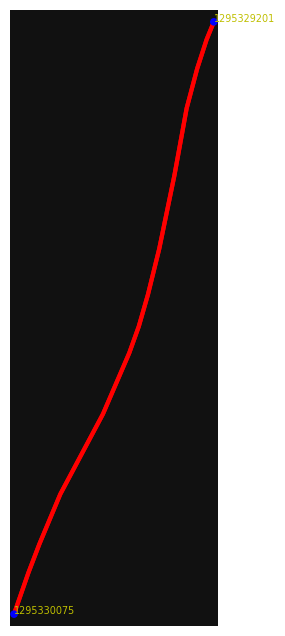

In [33]:
from cobra.flux_analysis import flux_variability_analysis

# osnovni model 0: uptake - križišče1 - cesta - križišče2 - secrete

# COBRApy model
model0 = cobra.Model('Mezica0')

krizisca = [1295329201, 1295330075]
# dodamo metabolite
for el in krizisca:
    indeks = nodes_list.index(el)
    metabolite0 = cobra.Metabolite(id=f'M{indeks}-{el}', name=f'Metabolite{indeks}-{el}', compartment='c')
    model0.add_metabolites([metabolite0])

# dodamo reakcije 
# najprej reakcije uničevanja vozil v križiščih
objectives0 = []

stevilo_reakcij = 0
for el in krizisca:
    reakcija = cobra.Reaction(id=f'R{stevilo_reakcij}-unicevanje', name=f'Reaction{stevilo_reakcij}-unicevanje')
    stevilo_reakcij += 1
    objectives0.append(reakcija)
    indeks = nodes_list.index(el)
    metabolit = model0.metabolites.get_by_id(f'M{indeks}-{el}')
    reakcija.add_metabolites({metabolit: -1.0})
    reakcija.upper_bound = 200.0
    model0.add_reactions([reakcija]) 

metabolit1 = model0.metabolites.get_by_id(f'M1-1295329201')
metabolit2 = model0.metabolites.get_by_id(f'M9-1295330075')
# uptake
reakcija = cobra.Reaction(id=f'R{stevilo_reakcij}-uptake', name=f'Reaction{stevilo_reakcij}-uptake')
stevilo_reakcij += 1
reakcija.add_metabolites({metabolit1: 1.0})
reakcija.upper_bound = 10000.0
reakcija.lower_bound = 2200.0
model0.add_reactions([reakcija]) 

# secrete
reakcija = cobra.Reaction(id=f'R{stevilo_reakcij}-secrete', name=f'Reaction{stevilo_reakcij}-secrete')
stevilo_reakcij += 1
reakcija.add_metabolites({metabolit2: -1.0})
reakcija.upper_bound = 2200.0
reakcija.lower_bound = 0.0
model0.add_reactions([reakcija]) 

# reakcije
reakcija = cobra.Reaction(id=f'R{stevilo_reakcij}', name=f'Reaction{stevilo_reakcij}')
stevilo_reakcij += 1
reakcija.add_metabolites({metabolit1: -1.0})
reakcija.add_metabolites({metabolit2: 1.0})
reakcija.upper_bound = 2100
model0.add_reactions([reakcija])

reakcija = cobra.Reaction(id=f'R{stevilo_reakcij}', name=f'Reaction{stevilo_reakcij}')
stevilo_reakcij += 1
reakcija.add_metabolites({metabolit1: 1.0})
reakcija.add_metabolites({metabolit2: -1.0})
reakcija.upper_bound = 2100
model0.add_reactions([reakcija])
      
    
obj = {item: -1.0 for item in objectives0}
uptakes_objective = {model0.reactions.get_by_id("R2-uptake") : 2.0}
obj.update(uptakes_objective)
model0.objective = obj


solution = model0.optimize()
print(solution)

for reaction in model0.reactions:
     print(reaction, solution.fluxes[reaction.id])
        
print(flux_variability_analysis(model0, model0.reactions))

#for reaction in model0.reactions:
#    print(reaction, reaction.lower_bound, reaction.upper_bound)

nodes_to_plot = krizisca
H = G.subgraph(nodes_to_plot)

fig3, ax3 = ox.plot_graph(H, dpi=100, node_size=30,  edge_linewidth=3, edge_color = 'r', node_color='b', show=False, close=False)
for el in nodes_to_plot:
    text = el
    c = nodes.iloc[nodes_list.index(el)]
    ax3.annotate(text, (c["x"], c["y"]), c='y', fontsize='x-small')
plt.show()

<Solution 4400.000 at 0x21864a46e00>
R0-unicevanje: M1-1295329201 -->  0.0
R1-unicevanje: M9-1295330075 -->  0.0
R2-unicevanje: M94-6544293474 -->  200.0
R3-uptake:  --> M94-6544293474 2300.0
R4-secrete: M9-1295330075 -->  2100.0
R5: M1-1295329201 --> M9-1295330075 2100.0
R6: M9-1295330075 --> M1-1295329201 0.0
R7: M1-1295329201 --> M94-6544293474 0.0
R8: M94-6544293474 --> M1-1295329201 2100.0
               minimum  maximum
R0-unicevanje      0.0      0.0
R1-unicevanje      0.0      0.0
R2-unicevanje    200.0    200.0
R3-uptake       2300.0   2300.0
R4-secrete      2100.0   2100.0
R5              2100.0   2100.0
R6                 0.0      0.0
R7                 0.0      0.0
R8              2100.0   2100.0


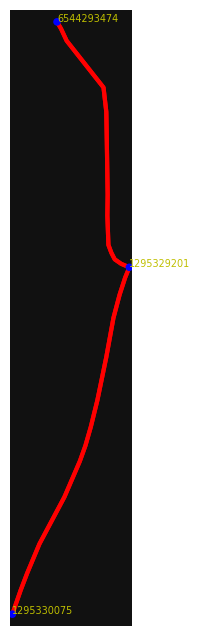

In [30]:
# osnovni model 1: uptake - križišče1 - cesta - križišče2 - križišče3- secrete

# COBRApy model
model1 = cobra.Model('Mezica1')

krizisca = [1295329201, 1295330075, 6544293474]
# dodamo metabolite
for el in krizisca:
    indeks = nodes_list.index(el)
    metabolite0 = cobra.Metabolite(id=f'M{indeks}-{el}', name=f'Metabolite{indeks}-{el}', compartment='c')
    model1.add_metabolites([metabolite0])

# dodamo reakcije 
# najprej reakcije uničevanja vozil v križiščih
objectives1 = []

stevilo_reakcij = 0
for el in krizisca:
    reakcija = cobra.Reaction(id=f'R{stevilo_reakcij}-unicevanje', name=f'Reaction{stevilo_reakcij}-unicevanje')
    stevilo_reakcij += 1
    objectives1.append(reakcija)
    indeks = nodes_list.index(el)
    metabolit = model1.metabolites.get_by_id(f'M{indeks}-{el}')
    reakcija.add_metabolites({metabolit: -1.0})
    reakcija.upper_bound = 200.0
    model1.add_reactions([reakcija]) 

metabolit1 = model1.metabolites.get_by_id(f'M1-1295329201')
metabolit2 = model1.metabolites.get_by_id(f'M9-1295330075')
metabolit3 = model1.metabolites.get_by_id(f'M94-6544293474')

# uptake
reakcija = cobra.Reaction(id=f'R{stevilo_reakcij}-uptake', name=f'Reaction{stevilo_reakcij}-uptake')
stevilo_reakcij += 1
reakcija.add_metabolites({metabolit3: 1.0})
reakcija.upper_bound = 10000.0
reakcija.lower_bound = 2200.0
model1.add_reactions([reakcija]) 

# secrete
reakcija = cobra.Reaction(id=f'R{stevilo_reakcij}-secrete', name=f'Reaction{stevilo_reakcij}-secrete')
stevilo_reakcij += 1
reakcija.add_metabolites({metabolit2: -1.0})
reakcija.upper_bound = 2200.0
reakcija.lower_bound = 0.0
model1.add_reactions([reakcija]) 

# reakcije

for idx in range(len(krizisca)-1):
    metabolit1 = model1.metabolites.get_by_id(f'M1-1295329201')
    reakcija = cobra.Reaction(id=f'R{stevilo_reakcij}', name=f'Reaction{stevilo_reakcij}')
    stevilo_reakcij += 1

    reakcija.add_metabolites({metabolit1: -1.0})
    node_id = krizisca[idx + 1]
    indeks = nodes_list.index(node_id)
    metabolit2 = model1.metabolites.get_by_id(f'M{indeks}-{node_id}')
    reakcija.add_metabolites({metabolit2: 1.0})
    reakcija.upper_bound = 2100
    model1.add_reactions([reakcija])
    
    reakcija = cobra.Reaction(id=f'R{stevilo_reakcij}', name=f'Reaction{stevilo_reakcij}')
    stevilo_reakcij += 1
    reakcija.add_metabolites({metabolit1: 1.0})
    reakcija.add_metabolites({metabolit2: -1.0})
    reakcija.upper_bound = 2100
    model1.add_reactions([reakcija])
    
        
obj = {item: -1.0 for item in objectives1}
uptakes_objective = {model1.reactions.get_by_id("R3-uptake") : 2.0}
obj.update(uptakes_objective)
model1.objective = obj


solution = model1.optimize()
print(solution)

for reaction in model1.reactions:
     print(reaction, solution.fluxes[reaction.id])

print(flux_variability_analysis(model1, model1.reactions))


#for reaction in model0.reactions:
#    print(reaction, reaction.lower_bound, reaction.upper_bound)

nodes_to_plot = [1295330075, 1295329201, 6544293474]
H = G.subgraph(nodes_to_plot)
fig3, ax3 = ox.plot_graph(H, dpi=100, node_size=30,  edge_linewidth=3, edge_color = 'r', node_color='b', show=False, close=False)
for el in nodes_to_plot:
    text = el
    c = nodes.iloc[nodes_list.index(el)]
    ax3.annotate(text, (c["x"], c["y"]), c='y', fontsize='x-small')
plt.show()

<Solution 4400.000 at 0x218644b8b20>
R0-unicevanje: M9-1295330075 -->  0.0
R1-unicevanje: M1-1295329201 -->  200.0
R2-uptake:  --> M1-1295329201 2300.0
R3-secrete: M3-1295329265 -->  2100.0
R4-secrete: M4-1295329315 -->  0.0
R5-secrete: M26-1356836576 -->  0.0
R6: M9-1295330075 --> M1-1295329201 0.0
R7: M1-1295329201 --> M9-1295330075 2100.0
R8: M9-1295330075 --> M3-1295329265 2100.0
R9: M3-1295329265 --> M9-1295330075 0.0
R10: M9-1295330075 --> M4-1295329315 0.0
R11: M4-1295329315 --> M9-1295330075 0.0
R12: M9-1295330075 --> M26-1356836576 0.0
R13: M26-1356836576 --> M9-1295330075 0.0
               minimum  maximum
R0-unicevanje      0.0      0.0
R1-unicevanje    200.0    200.0
R2-uptake       2300.0   2300.0
R3-secrete         0.0   2100.0
R4-secrete         0.0   2100.0
R5-secrete         0.0   2100.0
R6                 0.0      0.0
R7              2100.0   2100.0
R8                 0.0   2100.0
R9                 0.0   2100.0
R10                0.0   2100.0
R11                0.0 

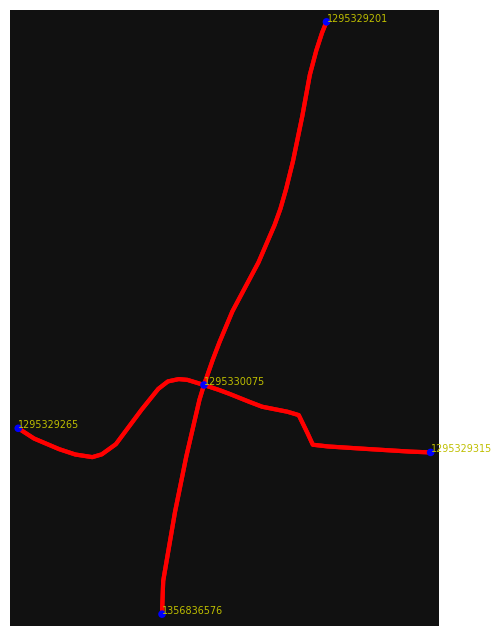

In [31]:
# osnovni model 2: razvejano križišče

# COBRApy model
model2 = cobra.Model('Mezica2')
    
krizisca = [1295330075, 1295329201, 1295329265, 1295329315, 1356836576]
# dodamo metabolite
for el in krizisca:
    indeks = nodes_list.index(el)
    metabolite0 = cobra.Metabolite(id=f'M{indeks}-{el}', name=f'Metabolite{indeks}-{el}', compartment='c')
    model2.add_metabolites([metabolite0])

# dodamo reakcije 
# najprej reakcije uničevanja vozil v križiščih
objectives2 = []
stevilo_reakcij = 0
for el in krizisca[:2]:
    reakcija = cobra.Reaction(id=f'R{stevilo_reakcij}-unicevanje', name=f'Reaction{stevilo_reakcij}-unicevanje')
    stevilo_reakcij += 1
    objectives2.append(reakcija)
    indeks = nodes_list.index(el)
    metabolit = model2.metabolites.get_by_id(f'M{indeks}-{el}')
    reakcija.add_metabolites({metabolit: -1.0})
    reakcija.upper_bound = 200.0
    model2.add_reactions([reakcija])  


# uptake
reakcija = cobra.Reaction(id=f'R{stevilo_reakcij}-uptake', name=f'Reaction{stevilo_reakcij}-uptake')
stevilo_reakcij += 1
metabolit = model2.metabolites.get_by_id(f'M1-1295329201')
reakcija.add_metabolites({metabolit: 1.0})
reakcija.upper_bound = 10000.0
reakcija.lower_bound = 2200.0
model2.add_reactions([reakcija]) 

# secrete
for el in krizisca[2:]:
    reakcija = cobra.Reaction(id=f'R{stevilo_reakcij}-secrete', name=f'Reaction{stevilo_reakcij}-secrete')
    stevilo_reakcij += 1
    indeks = nodes_list.index(el)
    metabolit = model2.metabolites.get_by_id(f'M{indeks}-{el}')
    reakcija.add_metabolites({metabolit: -1.0})
    reakcija.upper_bound = 2200.0
    reakcija.lower_bound = 0.0
    model2.add_reactions([reakcija]) 

# reakcije

for idx in range(len(krizisca)-1):
    metabolit1 = model2.metabolites.get_by_id(f'M9-1295330075')
    reakcija = cobra.Reaction(id=f'R{stevilo_reakcij}', name=f'Reaction{stevilo_reakcij}')
    stevilo_reakcij += 1

    reakcija.add_metabolites({metabolit1: -1.0})
    node_id = krizisca[idx + 1]
    indeks = nodes_list.index(node_id)
    metabolit2 = model2.metabolites.get_by_id(f'M{indeks}-{node_id}')
    reakcija.add_metabolites({metabolit2: 1.0})
    reakcija.upper_bound = 2100
    model2.add_reactions([reakcija])
    
    reakcija = cobra.Reaction(id=f'R{stevilo_reakcij}', name=f'Reaction{stevilo_reakcij}')
    stevilo_reakcij += 1
    reakcija.add_metabolites({metabolit1: 1.0})
    reakcija.add_metabolites({metabolit2: -1.0})
    reakcija.upper_bound = 2100
    model2.add_reactions([reakcija])
      
        
obj = {item: -1.0 for item in objectives2}
uptakes_objective = {model2.reactions.get_by_id("R2-uptake") : 2.0}
obj.update(uptakes_objective)
model2.objective = obj

solution = model2.optimize()
print(solution)

for reaction in model2.reactions:
     print(reaction, solution.fluxes[reaction.id])
        
print(flux_variability_analysis(model2, model2.reactions))

#for reaction in model0.reactions:
#    print(reaction, reaction.lower_bound, reaction.upper_bound)

H = G.subgraph(krizisca)
fig3, ax3 = ox.plot_graph(H, dpi=100, node_size=30,  edge_linewidth=3, edge_color = 'r', node_color='b', show=False, close=False)
for el in krizisca:
    text = el
    c = nodes.iloc[nodes_list.index(el)]
    ax3.annotate(text, (c["x"], c["y"]), c='y', fontsize='x-small')
plt.show()

<Solution 5000.000 at 0x21864427fa0>
R0-unicevanje: M94-6544293474 -->  200.0
R1-unicevanje: M15-1295330241 -->  200.0
R2-unicevanje: M93-6544293461 -->  200.0
R3-uptake:  --> M93-6544293461 2800.0
R4-secrete: M1-1295329201 -->  2200.0
R5: M1-1295329201 --> M94-6544293474 0.0
R6: M1-1295329201 --> M15-1295330241 0.0
R7: M15-1295330241 --> M1-1295329201 1900.0
R8: M94-6544293474 --> M1-1295329201 300.0
R9: M93-6544293461 --> M94-6544293474 500.0
R10: M94-6544293474 --> M93-6544293461 0.0
R11: M15-1295330241 --> M93-6544293461 0.0
R12: M93-6544293461 --> M15-1295330241 2100.0
               minimum  maximum
R0-unicevanje    200.0    200.0
R1-unicevanje    200.0    200.0
R2-unicevanje    200.0    200.0
R3-uptake       2800.0   2800.0
R4-secrete      2200.0   2200.0
R5                 0.0   1800.0
R6                 0.0   1800.0
R7               300.0   2100.0
R8               300.0   2100.0
R9               500.0   2100.0
R10                0.0   1600.0
R11                0.0   1600.0
R12

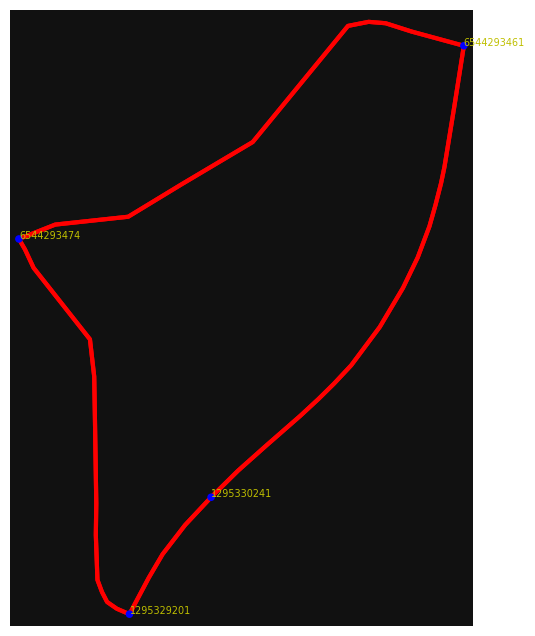

In [32]:
# osnovni model 3: razvejano križišče

# COBRApy model
model3 = cobra.Model('Mezica3')
    
krizisca = [1295329201, 6544293474, 1295330241, 6544293461]
# dodamo metabolite
for el in krizisca:
    indeks = nodes_list.index(el)
    metabolite0 = cobra.Metabolite(id=f'M{indeks}-{el}', name=f'Metabolite{indeks}-{el}', compartment='c')
    model3.add_metabolites([metabolite0])

# dodamo reakcije 
# najprej reakcije uničevanja vozil v križiščih
objectives3 = []
stevilo_reakcij = 0
for el in krizisca[1:]:
    reakcija = cobra.Reaction(id=f'R{stevilo_reakcij}-unicevanje', name=f'Reaction{stevilo_reakcij}-unicevanje')
    stevilo_reakcij += 1
    objectives3.append(reakcija)
    indeks = nodes_list.index(el)
    metabolit = model3.metabolites.get_by_id(f'M{indeks}-{el}')
    reakcija.add_metabolites({metabolit: -1.0})
    reakcija.upper_bound = 200.0
    model3.add_reactions([reakcija])  

# uptake
reakcija = cobra.Reaction(id=f'R{stevilo_reakcij}-uptake', name=f'Reaction{stevilo_reakcij}-uptake')
stevilo_reakcij += 1
metabolit = model3.metabolites.get_by_id(f'M93-6544293461')
reakcija.add_metabolites({metabolit: 1.0})
reakcija.upper_bound = 10000.0
reakcija.lower_bound = 2200.0
model3.add_reactions([reakcija]) 

# secrete
reakcija = cobra.Reaction(id=f'R{stevilo_reakcij}-secrete', name=f'Reaction{stevilo_reakcij}-secrete')
stevilo_reakcij += 1
metabolit = model3.metabolites.get_by_id(f'M1-1295329201')
reakcija.add_metabolites({metabolit: -1.0})
reakcija.upper_bound = 2200.0
reakcija.lower_bound = 0.0
model3.add_reactions([reakcija]) 

# reakcije
prave_reakcije = []
prave_reakcije_indeksi = []
ze_dodano = []
for el in krizisca:
    idx = nodes_list.index(el)
    counter = 0
    for el2 in M[idx, :]:
        if el2 != 0:
            indeks_ceste = counter
            if edges_list[indeks_ceste]["u"] in krizisca and edges_list[indeks_ceste]["v"] in krizisca:
                if indeks_ceste not in ze_dodano:
                    ze_dodano.append(indeks_ceste)
                    reakcija = cobra.Reaction(id=f'R{stevilo_reakcij}', name=f'Reaction{stevilo_reakcij}')
                    if (edges_list[indeks_ceste]["v"], edges_list[indeks_ceste]["u"]) not in prave_reakcije and (edges_list[indeks_ceste]["u"], edges_list[indeks_ceste]["v"]) not in prave_reakcije:
                        prave_reakcije.append((edges_list[indeks_ceste]["u"], edges_list[indeks_ceste]["v"]))
                        prave_reakcije_indeksi.append(stevilo_reakcij)
                    stevilo_reakcij += 1
                    indeks1 = nodes_list.index(edges_list[indeks_ceste]["u"])
                    indeks2 = nodes_list.index(edges_list[indeks_ceste]["v"])
                    metabolit1 = model3.metabolites.get_by_id(f'M{indeks1}-{edges_list[indeks_ceste]["u"]}')
                    metabolit2 = model3.metabolites.get_by_id(f'M{indeks2}-{edges_list[indeks_ceste]["v"]}')
                    reakcija.add_metabolites({metabolit1: -1})
                    reakcija.add_metabolites({metabolit2: 1})
                    reakcija.upper_bound = 2100
                    model3.add_reactions([reakcija])
        counter += 1
    

obj = {item: -1.0 for item in objectives3}
uptakes_objective = {model3.reactions.get_by_id("R3-uptake") : 2.0}
obj.update(uptakes_objective)
model3.objective = obj

solution = model3.optimize()
print(solution)

for reaction in model3.reactions:
     print(reaction, solution.fluxes[reaction.id])

#for reaction in model0.reactions:
#    print(reaction, reaction.lower_bound, reaction.upper_bound)

print(flux_variability_analysis(model3, model3.reactions))
H = G.subgraph(krizisca)
fig3, ax3 = ox.plot_graph(H, dpi=100, node_size=30,  edge_linewidth=3, edge_color = 'r', node_color='b', show=False, close=False)
for el in krizisca:
    text = el
    c = nodes.iloc[nodes_list.index(el)]
    ax3.annotate(text, (c["x"], c["y"]), c='y', fontsize='x-small')
plt.show()

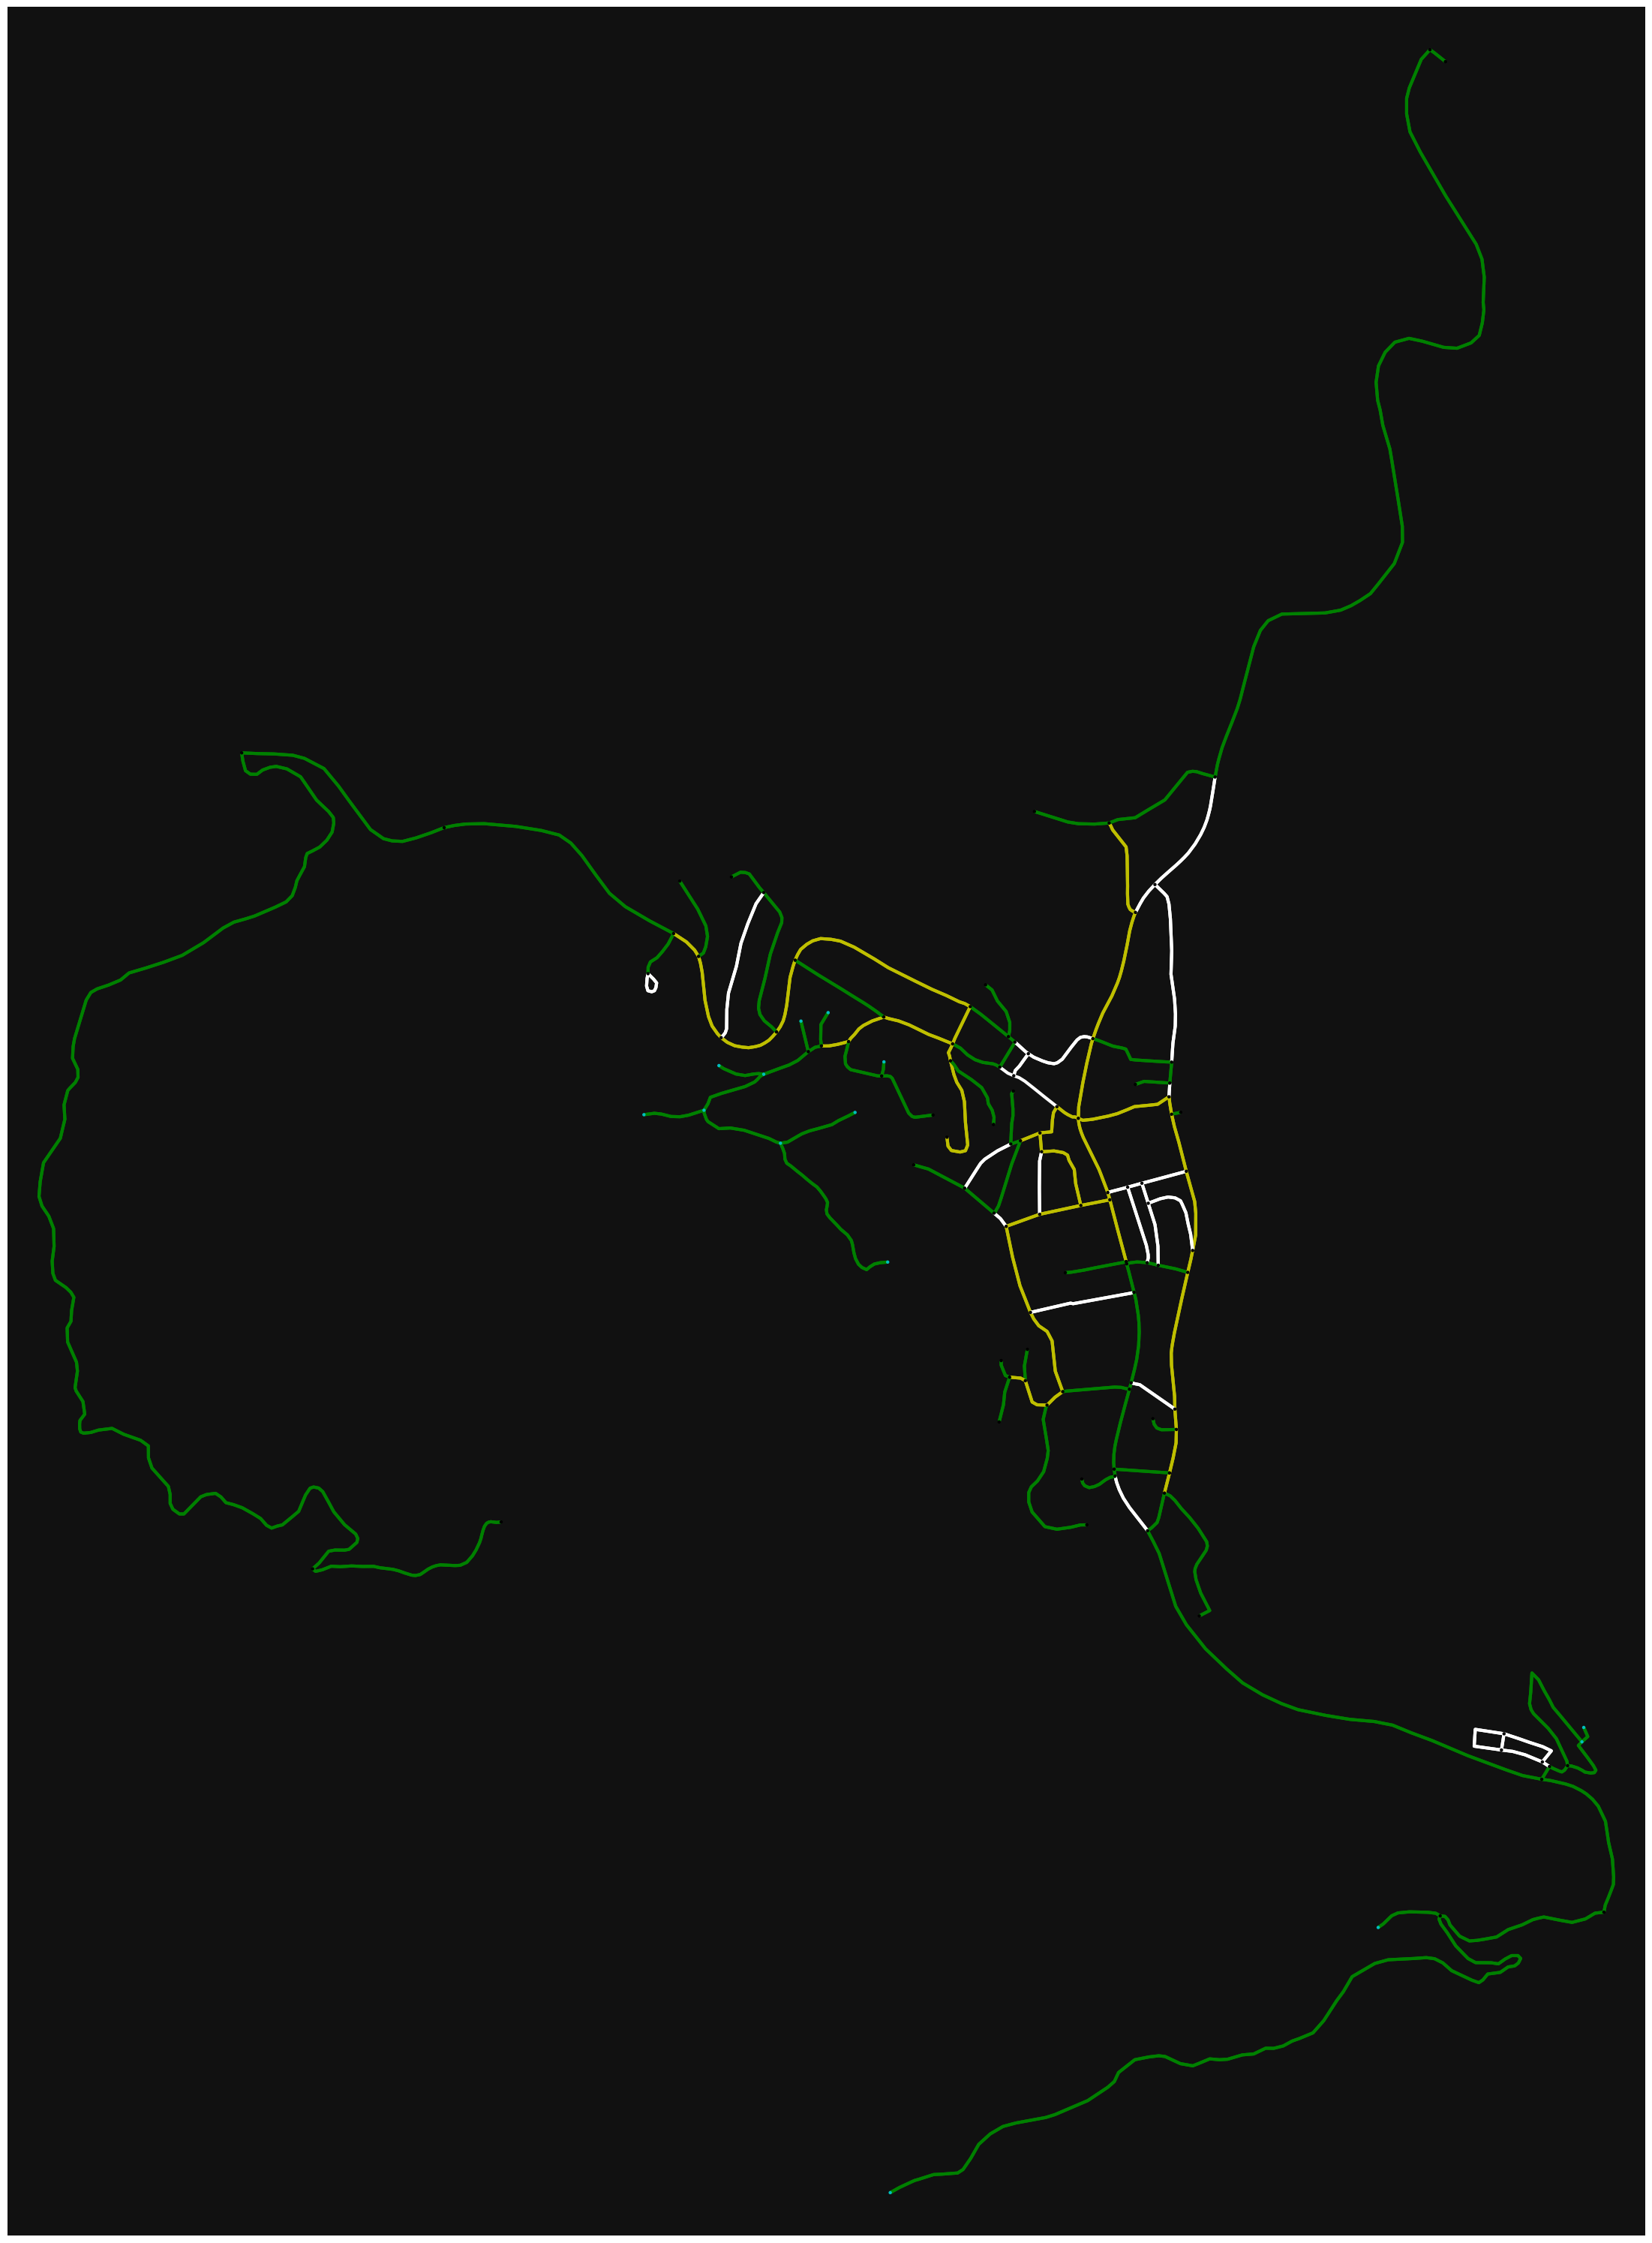

In [8]:
def najdi_pravi_edge(start, finish):
    indeksi = []
    counter = 0
    for i, row in edges.iterrows():
        if i[0] == start and i[1] == finish:
            indeksi.append(counter)
        elif i[0] == finish and i[1] == start:
            indeksi.append(counter)
        counter += 1
    return indeksi

# analiziramo pretoke po cestah in jih shranimo v tabelo, tam kjer so ločene dvosmerne ceste, bomo naredili
# vsoto pretoka v obeh smereh, ker se sicer na grafu ne prikazuje ustrezno
edges_fluxes = [0] * len(G.edges)

for reaction in model.reactions:
    try:
        r1 = reaction.reactants[0].id.split('-')[0].split('M')[1] 
        r1 = int(r1)
    except Exception:
        r1 = -1
    
    try:
        p1 = reaction.products[0].id.split('-')[0].split('M')[1]
        p1 = int(p1)
    except Exception:
        p1 = -1
    
    if r1 >= 0 and p1 >= 0:
        target_u = nodes_list[r1]
        target_v = nodes_list[p1]
        indeksi = najdi_pravi_edge(target_u, target_v)
        for ind in indeksi:
            edges_fluxes[ind] += the_solution.fluxes[reaction.id]


barve = ['']*len(G.edges)
for i in range(len(G.edges)):
    if edges_fluxes[i] < 1:
        barve[i] = 'w'
    elif edges_fluxes[i] >= 1 and edges_fluxes[i] <= 1000:
        barve[i] = 'g'
    elif edges_fluxes[i] > 1000 and edges_fluxes[i] < 2500:
        barve[i] = 'y'
    else:
        barve[i] = 'r'


# reakcije uničevanja
barve_krizisc = ['']*len(G.nodes)
for idx in range(len(G.nodes)):
    reac = model.reactions[idx]
    id_krizisca = reac.reactants[0].id.split('-')[1]
    tmp = 'c' if the_solution.fluxes[reac.id] > 0 else 'k'
    barve_krizisc[nodes_list.index(int(id_krizisca))] = tmp
    

fig2, ax2 = ox.plot_graph(G, figsize=(58.33, 38.57), dpi=100, node_size=10, edge_color=barve, edge_linewidth=3, node_color=barve_krizisc)